In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import sys
import matplotlib.pyplot as plt
from IPython import display

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
data = np.loadtxt(open('../sample_data/mnist_train_small.csv','rb'),delimiter=',')
data = data[:,1:]

data_norm = data / np.max(data)
data_norm = 2 * data_norm - 1
dataT = torch.tensor(data_norm).float()

batch_size = 32

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.fc1 = nn.Linear(28 * 28, 256)
        self.fc2 = nn.Linear(256, 256)
        self.out = nn.Linear(256, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.out(x)
        return torch.sigmoid(x)
    
discriminator = Discriminator()
y = discriminator(torch.randn(10, 784))
y

tensor([[0.4599],
        [0.4550],
        [0.4755],
        [0.4664],
        [0.4921],
        [0.4588],
        [0.5007],
        [0.4975],
        [0.4811],
        [0.4722]], grad_fn=<SigmoidBackward0>)

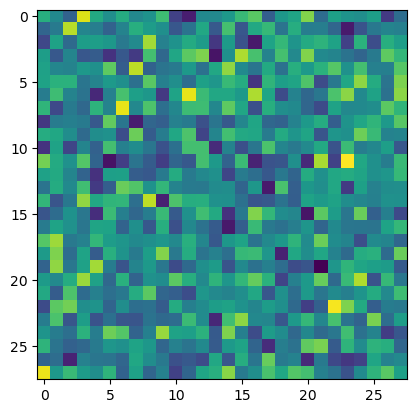

In [6]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(64, 256)
        self.fc2 = nn.Linear(256, 256)
        self.out = nn.Linear(256, 784)
    
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = self.out(x)
        return torch.tanh(x)

generator = Generator()
y = generator(torch.randn(10,64))
plt.imshow(y[0,:].detach().squeeze().view(28,28))

In [10]:
loss_fun = nn.BCELoss()

discriminator = Discriminator().to(device)
generator = Generator().to(device)

d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=.0005)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=.0005)

In [12]:
EPOCHS = 50000

losses = np.zeros((EPOCHS, 2))
dis_results = np.zeros((EPOCHS, 2))

for i in range(EPOCHS):

    # create mini batches of REAL and FAKE images
    idx = torch.randint(dataT.shape[0],(batch_size,))
    real_images = dataT[idx,:].to(device)
    fake_images = generator(torch.randn(batch_size, 64).to(device))

    # labels used for REAL and FAKE images
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)

    ### Train the discriminator

    # forward pass and loss for REAL pics
    pred_real = discriminator(real_images)
    d_loss_real = loss_fun(pred_real, real_labels)

    # Forward pass and loss for FAKE pics
    pred_fake = discriminator(fake_images)
    d_loss_fake = loss_fun(pred_fake, fake_labels)

    # Collect loss
    d_loss = d_loss_real + d_loss_fake
    losses[i,0] = d_loss.item()
    dis_results[i,0] = torch.mean((pred_real>.5).float()).detach()

    d_optimizer.zero_grad()
    d_loss.backward()
    d_optimizer.step()

    ### Train the generator

    # create fake images and compute loss
    fake_images = generator(torch.randn(batch_size,64).to(device))
    pred_fake = discriminator(fake_images)

    # Compute and collect loss and accuracy
    g_loss = loss_fun(pred_fake, real_labels)
    losses[i,1] = g_loss.item()
    dis_results[i,1] = torch.mean((pred_fake>.5).float()).detach()

    g_optimizer.zero_grad()
    g_loss.backward()
    g_optimizer.step()

    if (i+1) % 500 == 0:
        print(f"Epoch {i+1}: d_loss = {d_loss}, g_loss = {g_loss}")
        

Epoch 500: d_loss = 0.05578891932964325, g_loss = 3.8826842308044434
Epoch 1000: d_loss = 0.6438361406326294, g_loss = 1.7177406549453735
Epoch 1500: d_loss = 2.213679313659668, g_loss = 0.5613267421722412
Epoch 2000: d_loss = 0.8029013872146606, g_loss = 1.0898857116699219
Epoch 2500: d_loss = 2.3392200469970703, g_loss = 0.6403195858001709
Epoch 3000: d_loss = 0.5399391651153564, g_loss = 3.3691811561584473
Epoch 3500: d_loss = 0.9673193693161011, g_loss = 1.5021976232528687
Epoch 4000: d_loss = 0.9131048321723938, g_loss = 2.306739091873169
Epoch 4500: d_loss = 0.8960102796554565, g_loss = 1.7806119918823242
Epoch 5000: d_loss = 1.3616245985031128, g_loss = 0.8907240629196167
Epoch 5500: d_loss = 0.2130976915359497, g_loss = 2.9057681560516357
Epoch 6000: d_loss = 0.49049440026283264, g_loss = 4.249121189117432
Epoch 6500: d_loss = 0.6454743146896362, g_loss = 2.1509575843811035
Epoch 7000: d_loss = 0.5398709177970886, g_loss = 2.558467149734497
Epoch 7500: d_loss = 1.32730269432067

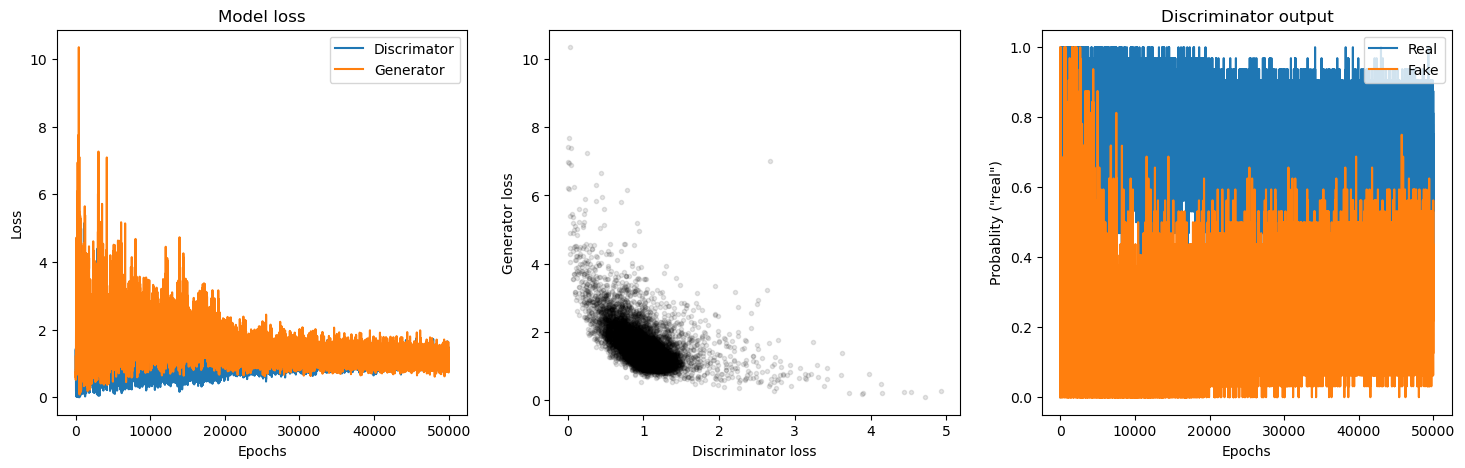

In [16]:
fig,ax = plt.subplots(1,3,figsize=(18,5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')
ax[0].legend(['Discrimator','Generator'])
# ax[0].set_xlim([4000,5000])

ax[1].plot(losses[::5,0],losses[::5,1],'k.',alpha=.1)
ax[1].set_xlabel('Discriminator loss')
ax[1].set_ylabel('Generator loss')

ax[2].plot(dis_results)
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Probablity ("real")')
ax[2].set_title('Discriminator output')
ax[2].legend(['Real','Fake'])

plt.show()

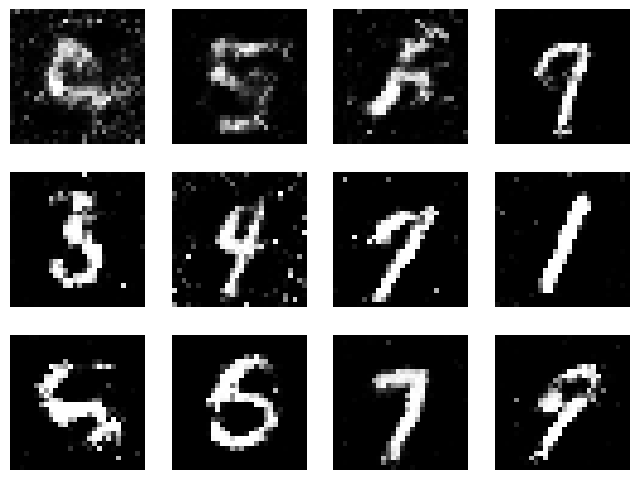

In [20]:
# generate the images from the generator network
generator.eval()
fake_data = generator(torch.randn(12,64).to(device)).cpu()

# and visualize...
fig,axs = plt.subplots(3,4,figsize=(8,6))
for i,ax in enumerate(axs.flatten()):
  ax.imshow(fake_data[i,:,].detach().view(28,28),cmap='gray')
  ax.axis('off')

plt.show()